# Merge and replace strategies & Advanced tricks


# **Recap**


---
## **`dlt` write dispositions**

Write disposition in the context of the dlt library defines how the data should be written to the destination. There are three types of write dispositions:

* **Append**: This is the **default** disposition. It will append the data to the existing data in the destination.

* **Replace**: This disposition replaces the data in the destination with the data from the resource. It **deletes** all the data and **recreates** the schema before loading the data.

* **Merge**: This write disposition merges the data from the resource with the data at the destination. For the merge disposition, you need to specify a `primary_key` for the resource.

The write disposition you choose depends on the dataset and how you can extract it. For more details, you can refer to the [Incremental loading page](https://dlthub.com/docs/general-usage/incremental-loading).



A `write_disposition` in `dlt` can specified in the resource decorator:

```python
@dlt.resource(write_disposition="append")
def my_resource():
  ...
  yield data
```

Or directly in the pipeline run:

```python
load_info = pipeline.run(my_resource, write_disposition="replace")
```

> In case you specify both, the write disposition specified at the pipeline run level will override the write disposition specified at the resource level.

---

### **Replace**

The `replace` strategy in the dlt library is used for **full loading** of data. This strategy completely overwrites the existing data with the new dataset. It's useful when you want to refresh the entire table with the latest data. It's important to note that this strategy technically does not load only new data but instead reloads all data: old and new.

**Example: E-commerce Product Catalog refresh**

- A large retailer (e.g., Amazon) needs to refresh their product catalog daily.

- Using a replace strategy ensures all product details are up-to-date and no longer available products are removed.

- Critical for ensuring customers see only valid products and prices.

**Importance**: Guarantees consistency and accuracy in fast-changing datasets where full refreshes are simpler than merging updates.

**Risks**: Data downtime if the refresh fails or takes too long.

In dlt, you can control how the data is loaded into the destination table by setting the `write_disposition` parameter in the resource configuration. When you set the `write_disposition` to `replace`, it replaces the data in the destination table with the new data.

For more details, you can refer to the following documentation pages:

- [Full loading](https://dlthub.com/docs/general-usage/full-loading)
- [Write dispositions](https://dlthub.com/docs/general-usage/incremental-loading#the-3-write-dispositions)


---
### **Merge**

Consider a scenario where the data in the source has been updated, but you want to avoid reloading the entire dataset.

**Example: Customer data integration (e.g., Salesforce CRM)**

- A business integrates Salesforce CRM data with its data warehouse.

- Sales representatives continuously update customer profiles. A merge strategy ensures that only the changed records are updated without affecting the entire dataset.

- Useful for integrating various CRM systems where incremental updates are preferred over full reloads.

Merge write disposition is used to merge new data into the destination, using a `merge_key` and/or **deduplicating**/**upserting** new data using a `primary_key`.




The **merge** write disposition can be useful in several situations:

1.  If you have a dataset where records are frequently updated and you want to reflect these changes in your database, the merge write disposition can be used. It will **update the existing records** with the new data instead of creating duplicate entries.

2. If your data source occasionally sends **duplicate records**, the merge write disposition can help handle this. It uses a `primary_key` to identify unique records, so if a duplicate record (with the same `primary_key`) is encountered, it will be merged with the existing record instead of creating a new one.

3. If you are dealing with **Slowly Changing Dimensions** (SCD) where the attribute of a record changes over time and you want to maintain a history of these changes, you can use the merge write disposition with the scd2 strategy.


When using the merge disposition, you need to specify a `primary_key` or `merge_key` for the resource.


---

# **More about write dispositions and incremental loading** ⚙️🧠

**In the dlt Fundamentals course we've already discussed:**
- `dlt` write dispositions:
  - Append
  - Replace
  - Merge
- What incremental loading is.

**Now, we will cover** the different strategies for `merge` write disposition:
- `delete-insert` strategy.
- `upsert` strategy.
- `SCD2` strategy.

We also will take a look at
* Hard deletes.
* Falling back for incremental cursors.
* Backfills.

---

## **Replace strategies**

In this lesson, we will explore the concept of **full loading**, where we completely reload the data of our tables, removing all existing data and replacing it with new data from our source.


We will also delve into the different replace strategies that dlt implements for doing a full load on your table:
- `truncate-and-insert`,
- `insert-from-staging`,  
- `staging-optimized`.



Each of these strategies has its own unique characteristics and use cases, and we will discuss them in detail.



### **I. Truncate-and-Insert Strategy**

**Overview**

The `truncate-and-insert` strategy is the **default** replace strategy in dlt and is the **fastest** of all three strategies. This strategy is particularly useful when you want to completely refresh your data and you don't need to maintain the existing data in your tables during the load process.

When you load data with the `truncate-and-insert` strategy, the destination tables will be truncated at the beginning of the load. This means that all existing data in the tables will be removed. After truncating the tables, the new data will be inserted. The insertion of new data happens consecutively but not within the same transaction.

**Example: Daily ETL job for financial reports (e.g., Bloomberg Terminal Data)**

- Daily financial summaries are generated and processed overnight.

- Using `truncate-and-insert`, the pipeline ensures that analysts work with the most recent data every morning.

**Configuration**

You can select the `truncate-and-insert` strategy with a setting in your `config.toml` file.

```yaml
[destination]
replace_strategy = "truncate-and-insert"
```

**Limitations**

However, it's important to note that the **downside** of this strategy is that your **tables will have no data for a while** until the load is completed. You may end up with new data in some tables and no data in other tables if the load fails during the run. Such an incomplete load may be detected by checking if the `_dlt_loads` table contains a load id from `_dlt_load_id` of the replaced tables. If you prefer to have no data downtime, please use one of the other strategies.


Here's an example of how to use the `truncate-and-insert` strategy with the Pokemon data:


In [1]:
%%capture
!pip install "dlt[duckdb]"

In [2]:
import dlt
from datetime import datetime

data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}},
]


dlt.secrets["destination.replace_strategy"] = "truncate-and-insert" # <--- set the replace strategy using TOML, ENVs or Python

pipeline = dlt.pipeline(
    pipeline_name="pokemon_load_1",
    destination="duckdb",
    dataset_name="pokemon_data_1",
)

load_info = pipeline.run(data, table_name="pokemon", write_disposition="replace")
print(pipeline.last_trace)

Run started at 2025-05-10 10:04:07.540922+00:00 and COMPLETED in 4.50 seconds with 4 steps.
Step extract COMPLETED in 0.27 seconds.

Load package 1746871448.7389727 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.06 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- pokemon: 3 row(s)

Load package 1746871448.7389727 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 3.18 seconds.
Pipeline pokemon_load_1 load step completed in 0.53 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data_1
The duckdb destination used duckdb:////content/pokemon_load_1.duckdb location to store data
Load package 1746871448.7389727 is LOADED and contains no failed jobs

Step run COMPLETED in 4.49 seconds.
Pipeline pokemon_load_1 load step completed in 0.53 seconds
1 load package(s) were loaded to destination duckdb and into data

In [3]:
with pipeline.sql_client() as client:
    with client.execute_query("SHOW ALL TABLES") as table:
        tables = table.df()

tables

,database,schema,name,column_names,column_types,temporary
0,pokemon_load_1,pokemon_data_1,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,pokemon_load_1,pokemon_data_1,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,pokemon_load_1,pokemon_data_1,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,pokemon_load_1,pokemon_data_1,pokemon,"[id, name, size__weight, size__height, _dlt_lo...","[VARCHAR, VARCHAR, DOUBLE, DOUBLE, VARCHAR, VA...",False




In this example, we're using the `replace_strategy="truncate-and-insert"` parameter in the pipeline method to indicate that we want to use the `truncate-and-insert` strategy for replacing data.



### **II. Insert-from-staging Strategy**

**Overview**

The `insert-from-staging` strategy is used when you want to maintain a consistent state between nested and root tables at all times, with zero downtime. This strategy loads all new data into staging tables away from your final destination tables and then truncates and inserts the new data in one transaction.

**Example: Airline reservation systems (e.g., Amadeus, Sabre)**

- Ensuring that updated flight availability information doesn't interrupt user queries during ingestion.

- Data is first written to staging tables and only swapped to production tables when the operation is complete.

**Configuration**

You can select the `insert-from-staging` strategy with a setting in your `config.toml` file. If you do not select a strategy, dlt will default to `truncate-and-insert`.

```yaml
[destination]
replace_strategy = "insert-from-staging"
```

**Limitations**

The `insert-from-staging` strategy, while ensuring zero downtime and maintaining a consistent state between nested and root tables, is **the slowest** of all three strategies. It loads all new data into staging tables away from your final destination tables and then truncates and inserts the new data in one transaction. This process can be time-consuming, especially for large datasets.

Here's an example of how you can use this strategy:

In [4]:
import dlt

data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}},
]



dlt.secrets["destination.replace_strategy"] = "insert-from-staging" # <--- set the replace strategy using TOML, ENVs or Python

pipeline = dlt.pipeline(
    pipeline_name="pokemon_load_2",
    destination="duckdb",
    dataset_name="pokemon_data_2",
)

load_info = pipeline.run(data, table_name="pokemon", write_disposition="replace")

print(pipeline.last_trace)

Run started at 2025-05-10 10:04:12.285722+00:00 and COMPLETED in 0.61 seconds with 4 steps.
Step extract COMPLETED in 0.06 seconds.

Load package 1746871452.4329293 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.05 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- pokemon: 3 row(s)

Load package 1746871452.4329293 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.36 seconds.
Pipeline pokemon_load_2 load step completed in 0.34 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data_2
The duckdb destination used duckdb:////content/pokemon_load_2.duckdb location to store data
Load package 1746871452.4329293 is LOADED and contains no failed jobs

Step run COMPLETED in 0.61 seconds.
Pipeline pokemon_load_2 load step completed in 0.34 seconds
1 load package(s) were loaded to destination duckdb and into data

In [5]:
with pipeline.sql_client() as client:
    with client.execute_query("SHOW ALL TABLES") as table:
        tables = table.df()

tables

,database,schema,name,column_names,column_types,temporary
0,pokemon_load_2,pokemon_data_2,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,pokemon_load_2,pokemon_data_2,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,pokemon_load_2,pokemon_data_2,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,pokemon_load_2,pokemon_data_2,pokemon,"[id, name, size__weight, size__height, _dlt_lo...","[VARCHAR, VARCHAR, DOUBLE, DOUBLE, VARCHAR, VA...",False
4,pokemon_load_2,pokemon_data_2_staging,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
5,pokemon_load_2,pokemon_data_2_staging,pokemon,"[id, name, size__weight, size__height, _dlt_lo...","[VARCHAR, VARCHAR, DOUBLE, DOUBLE, VARCHAR, VA...",False


We see the introduction of the [staging](https://dlthub.com/docs/dlt-ecosystem/staging) schema called `pokemon_data_2_staging`.

> We will discuss Staging in more detail in the following lessons.

In this example, the `insert-from-staging` strategy will load the pokemon data **into a staging table** in the `pokemon_data_2_staging` schema in DuckDB (or any other destination you choose).  

Let's check the content of this table:

In [6]:
with pipeline.sql_client() as client:
    with client.execute_query("SELECT * from pokemon_data_2_staging.pokemon") as table:
        tables = table.df()

tables

,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1746871452.4329293,UZWNJp+KUHqc/g
1,4,charmander,8.5,0.6,1746871452.4329293,+zK+Hum0AT3W4A
2,25,pikachu,6.0,0.4,1746871452.4329293,AdN1jvK6EG717w


We see that the staging table contains all the data we loaded.



dlt will then **truncate** the destination table and **insert** the new data in one transaction, ensuring that the destination dataset is always in a consistent state.

For more details about the `insert-from-staging` strategy, you can refer to the [dlt documentation.](https://dlthub.com/docs/general-usage/full-loading#the-insert-from-staging-strategy)

### **III. Staging-optimized Strategy**


The `staging-optimized` replace strategy is one of the three strategies implemented by dlt for doing a full load on your table.

**Overview**

The `staging-optimized` strategy **combines the benefits** of the `insert-from-staging` strategy with certain optimizations for **faster** loading on some destinations. However, it comes with a **trade-off**: destination tables may be dropped and recreated in some cases. This means that any views or other constraints you have placed on those tables will be dropped with the table.

If you have a setup where you need to retain your destination tables, you should not use the `staging-optimized` strategy. On the other hand, if you do not care about tables being dropped but need the benefits of the `insert-from-staging` with some performance (and cost) saving opportunities, this strategy is a good choice.

**Example: Data warehousing for Business Intelligence (e.g., Snowflake, BigQuery)**

- When refreshing tables with daily marketing analytics, staging-optimized strategy uses clone operations.

- Clone operations in platforms like Snowflake are fast and cost-effective since they avoid data copying.

**How it works**

The `staging-optimized` strategy behaves differently across destinations:

- **Postgres**: After loading the new data into the staging tables, the destination tables will be dropped and replaced by the staging tables. No data needs to be moved, so this strategy is almost as fast as `truncate-and-insert`.

- **BigQuery**: After loading the new data into the staging tables, the destination tables will be dropped and recreated with a clone command from the staging tables. This is a low-cost and fast way to create a second independent table from the data of another. You can learn more about table cloning on BigQuery [here](https://dlthub.com/docs/dlt-ecosystem/destinations/bigquery).

- **Snowflake**: After loading the new data into the staging tables, the destination tables will be dropped and recreated with a clone command from the staging tables. This is a low-cost and fast way to create a second independent table from the data of another. You can learn more about table cloning on Snowflake [here](https://dlthub.com/docs/dlt-ecosystem/destinations/snowflake).

- For all **other destinations**, please look at their respective [documentation](https://dlthub.com/docs/dlt-ecosystem/destinations/) pages to see if and how the `staging-optimized` strategy is implemented. If it is not implemented, dlt will fall back to the `insert-from-staging` strategy.

**Configuration**

You can select the `staging-optimized` strategy with a setting in your `config.toml` file. If you do not select a strategy, dlt will default to `truncate-and-insert`.

```yaml
[destination]
# Set the optimized replace strategy
replace_strategy = "staging-optimized"
```

**Limitations**

It's important to note that the `staging-optimized` replace strategy is **not implemented for all destinations**. For example, DuckDB doesn't support this strategy, that's why we skip the code example.

---
## **Merge strategies**

Append and replace write dispositions are quite simple to use, but with `merge` you need to be more careful.

Let's create an example database

In [7]:
%%capture
!pip install "dlt[duckdb]"

Let's remember our Pokemon data sample from the dlt Fundamentals course:


In [8]:
# Sample data containing pokemon details
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}},
]

Load this data into duckdb with merge write disposition.

In [9]:
import dlt

@dlt.resource(
    name='pokemon',
    write_disposition='merge',
    primary_key="id",
)
def pokemon():
    yield data


pipeline = dlt.pipeline(
    pipeline_name="poke_pipeline_merge",
    destination="duckdb",
    dataset_name="pokemon_data",
)

load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline_merge load step completed in 0.32 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline_merge.duckdb location to store data
Load package 1746871456.616978 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,25,pikachu,6.0,0.4,1746871456.616978,FoQY0QI4LVpCEg
1,4,charmander,8.5,0.6,1746871456.616978,967r8ZZnfSuavw
2,1,bulbasaur,6.9,0.7,1746871456.616978,LQ/XzTR/s0kP3Q


The merge write disposition can be used with three different strategies:

* delete-insert (default strategy)
* scd2
* upsert


Let's explore these strategies closer.

### **I. `delete-insert` strategy**

**Overview**

The `merge` write disposition has `delete-insert` as the default strategy. Since we haven't specified a strategy in the previous example, this is what was used by default under the hood.

The `delete-insert` strategy loads data to a **`staging`** dataset, deduplicates the `staging` data if a `primary_key` is provided, **deletes** the data from the destination using `merge_key` and `primary_key`, and then **inserts** the new records.

> The `merge_key` is used in the `delete-insert` strategy to determine which records to delete from the destination before inserting the new records.

**Example: Streaming analytics (e.g., Kafka → Data Warehouse)**

- Streaming logs are ingested with a `delete-insert` strategy to remove outdated entries and ensure only fresh data remains.

- Used when a `merge_key` is provided, allowing old entries to be purged before new ones are inserted.


Imagine that we want to load only updated data:

In [10]:
# Sample data containing pokemon details
data = [
    {"id": "25", "name": "pikachu", "size": {"weight": 7.5, "height": 0.4}},  # <--- Pikachu's weight has increased
]

Run the pipeline again:

In [11]:
load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline_merge load step completed in 0.16 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline_merge.duckdb location to store data
Load package 1746871457.2897005 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,4,charmander,8.5,0.6,1746871456.616978,967r8ZZnfSuavw
1,1,bulbasaur,6.9,0.7,1746871456.616978,LQ/XzTR/s0kP3Q
2,25,pikachu,7.5,0.4,1746871457.2897005,puUeqbaSbAc7kw


Data was updated, pikachu data has changed, now he has a different `_dlt_load_id`.

Let's check what happened in the database in the previous run:

In [12]:
with pipeline.sql_client() as client:
    with client.execute_query("SHOW ALL TABLES") as table:
        tables = table.df()

tables

,database,schema,name,column_names,column_types,temporary
0,poke_pipeline_merge,pokemon_data,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,poke_pipeline_merge,pokemon_data,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,poke_pipeline_merge,pokemon_data,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,poke_pipeline_merge,pokemon_data,pokemon,"[id, name, size__weight, size__height, _dlt_lo...","[VARCHAR, VARCHAR, DOUBLE, DOUBLE, VARCHAR, VA...",False
4,poke_pipeline_merge,pokemon_data_staging,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
5,poke_pipeline_merge,pokemon_data_staging,pokemon,"[id, name, size__weight, size__height, _dlt_lo...","[VARCHAR, VARCHAR, DOUBLE, DOUBLE, VARCHAR, VA...",False


We see agian the staging schema called `pokemon_data_staging`. Let's check the content:

In [13]:
with pipeline.sql_client() as client:
    with client.execute_query("SELECT * from pokemon_data_staging.pokemon") as table:
        tables = table.df()

tables

,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,25,pikachu,7.5,0.4,1746871457.2897005,puUeqbaSbAc7kw


We see that only new row is in the staging table. Since we used primary key, `dlt` deleted the previous entry of Pikachu and then inserted the new one.

### **II. `upsert` strategy**

**Overview**

The upsert merge strategy does `primary_key` based upserts:

- update record if key exists in target table
- insert record if key does not exist in target table

```
@dlt.resource(
    write_disposition={"disposition": "merge", "strategy": "upsert"},
    primary_key="my_primary_key"
)
def my_upsert_resource():
    ...
...
```

**Difference between upsert and delete-insert**

1. needs a `primary_key`
2. expects this `primary_key` to be unique (`dlt` does not deduplicate)
3. does not support `merge_key`
4. uses MERGE or UPDATE operations to process updates


**Example: Customer data management (e.g., HubSpot, Salesforce)**

- Continuous synchronization of customer profiles across multiple systems.

- Any update to an existing customer is reflected without deleting unrelated data.

***Not supported in DuckDB.** List of supported destinations can be found in [docs](https://dlthub.com/docs/general-usage/incremental-loading#upsert-strategy).

### **III. `SCD2` strategy**

**Overview**

`dlt` can create Slowly Changing Dimensions Type 2 (SCD2) destination tables for dimension tables that change in the source.

The resource is expected to provide a full extract of the source table each run.

A row hash is stored in `_dlt_id` and used as surrogate key to identify source records that have been inserted, updated, or deleted.

**Example: Financial transaction systems (e.g., Mastercard, Visa)**

- Keeping history of account balances over time for auditing purposes.

- Allows analysts to trace how data evolved, which is critical for compliance and troubleshooting.



Before running the pipeline, let's re-use our small Pokemon dataset:

In [14]:
%%capture
!pip install dlt

In [15]:
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}},
    {"id": "25", "name": "pikachu", "size": {"weight": 7.5, "height": 0.4}},
]

Now, run the pipeline with merge disposition and SCD2 strategy:

In [16]:
import dlt

@dlt.resource(
    name='pokemon',
    write_disposition={
        "disposition": "merge", # <--- specifies that existing data should be merged
        "strategy": "scd2" # <--- enables SCD2 tracking, which keeps historical records of changes
    },
    primary_key="id",
)
def pokemon():
    yield data

pipeline = dlt.pipeline(
    pipeline_name="pokemon_pipeline",
    destination="duckdb",
    dataset_name="pokemon_scd2",
)


load_info = pipeline.run(pokemon)
print(load_info)

Pipeline pokemon_pipeline load step completed in 0.34 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_scd2
The duckdb destination used duckdb:////content/pokemon_pipeline.duckdb location to store data
Load package 1746871463.5816185 is LOADED and contains no failed jobs


Check what happened:

In [17]:
# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

,_dlt_valid_from,_dlt_valid_to,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,2025-05-10 10:04:23.581619+00:00,NaT,1,bulbasaur,6.9,0.7,1746871463.5816185,JWXIMt9lw9f5Ug
1,2025-05-10 10:04:23.581619+00:00,NaT,4,charmander,8.5,0.6,1746871463.5816185,zP/l4OrMP8LLvw
2,2025-05-10 10:04:23.581619+00:00,NaT,25,pikachu,7.5,0.4,1746871463.5816185,PVWqhUrvtKyN3g


New columns were created:

- `_dlt_valid_from` – The timestamp when this record was first inserted into the table.
  - All records have the same value, which is when the pipeline first processed them.

- `_dlt_valid_to` – The timestamp when this record was considered outdated.
  - NaT (Not a Time) means that these records are currently active and have not been superseded by newer versions.

Modify the dataset by changing Pikachu weight again. This simulates a change in source data that should be tracked by SCD2:

In [18]:
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}}, # <--- weight has changed back
]

Run the pipeline again with the modified dataset:

In [19]:
load_info = pipeline.run(pokemon)
print(load_info)

Pipeline pokemon_pipeline load step completed in 0.21 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_scd2
The duckdb destination used duckdb:////content/pokemon_pipeline.duckdb location to store data
Load package 1746871464.196536 is LOADED and contains no failed jobs


Check the database:

In [20]:
pipeline.dataset(dataset_type="default").pokemon.df()

,_dlt_valid_from,_dlt_valid_to,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,2025-05-10 10:04:23.581619+00:00,NaT,1,bulbasaur,6.9,0.7,1746871463.5816185,JWXIMt9lw9f5Ug
1,2025-05-10 10:04:23.581619+00:00,NaT,4,charmander,8.5,0.6,1746871463.5816185,zP/l4OrMP8LLvw
2,2025-05-10 10:04:23.581619+00:00,2025-05-10 10:04:24.196536+00:00,25,pikachu,7.5,0.4,1746871463.5816185,PVWqhUrvtKyN3g
3,2025-05-10 10:04:24.196536+00:00,NaT,25,pikachu,6.0,0.4,1746871464.196536,MvflYQ8JIFOZ1g


SCD2 created a new row for Pikachu with updated `size_weight` to 6.0 while keeping the historical record.



---
## **Hard-deletes**

The `hard_delete` column hint can be used to delete records from the destination dataset. The behavior of the delete mechanism depends on the data type of the column marked with the hint:

* `bool` type: only `True` leads to a delete, `None` and `False` values are disregarded.
* Other types: each not `None` value leads to a delete.

Each record in the destination table with the same `primary_key` or `merge_key` as a record in the source dataset that's marked as a delete will be deleted.

Deletes are propagated to any nested table that might exist. For each record that gets deleted in the root table, all corresponding records in the nested table(s) will also be deleted.

**Example: User account deletion (GDPR Compliance)**

- An online social platform (e.g., Instagram, Facebook) allows users to permanently delete their accounts.

- When a user requests account deletion, their data must be removed from the production dataset to comply with GDPR or CCPA requirements.

- By marking records with a `deleted_flag = True`, the system ensures the user’s data is completely removed from the production tables during the next load operation.

In [21]:
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}, "deleted_flag": True},  # <--- should be deleted
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}, "deleted_flag": None},  # <--- should be kept
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}, "deleted_flag": False},  # <--- should be kept
]

In [22]:
import dlt

@dlt.resource(
    name='pokemon',
    write_disposition='merge',
    primary_key="id",
    columns={"deleted_flag": {"hard_delete": True}} # <--- set columns argument
)
def pokemon():
    yield data

pipeline = dlt.pipeline(
    pipeline_name="pokemon_pipeline",
    destination="duckdb",
    dataset_name="pokemon_hd",
)


load_info = pipeline.run(pokemon)
print(load_info)

Pipeline pokemon_pipeline load step completed in 0.39 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_hd
The duckdb destination used duckdb:////content/pokemon_pipeline.duckdb location to store data
Load package 1746871464.8627572 is LOADED and contains no failed jobs


In [23]:
pipeline.dataset(dataset_type="default").pokemon.df()

,id,name,size__weight,size__height,deleted_flag,_dlt_load_id,_dlt_id
0,25,pikachu,6.0,0.4,False,1746871464.8627572,PcjECJVbNR9Hvg
1,4,charmander,8.5,0.6,<NA>,1746871464.8627572,sktZfYcJsnZkGA


Bulbasaur wasn't loaded at all.

Let's see if can remove data from loaded data:



In [24]:
data = [
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}, "deleted_flag": True},  # <--- set to True
]

In [25]:
load_info = pipeline.run(pokemon)
print(load_info)

Pipeline pokemon_pipeline load step completed in 0.22 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_hd
The duckdb destination used duckdb:////content/pokemon_pipeline.duckdb location to store data
Load package 1746871465.5040329 is LOADED and contains no failed jobs


In [26]:
pipeline.dataset(dataset_type="default").pokemon.df()

,id,name,size__weight,size__height,deleted_flag,_dlt_load_id,_dlt_id
0,4,charmander,8.5,0.6,<NA>,1746871464.8627572,sktZfYcJsnZkGA


Pikachu record was deleted from loaded data.

#### **Deduplication**

By default, `primary_key` deduplication is arbitrary. You can pass the `dedup_sort` column hint with a value of `desc` or `asc` to influence which record remains after deduplication.

- Using `desc`, the records sharing the same `primary_key` are sorted in **descending** order before deduplication, making sure the record with the highest value for the column with the `dedup_sort` hint remains.

- `asc` has the opposite behavior.


**Example: Email marketing platforms (e.g., Mailchimp, SendGrid)**

- Users may accidentally submit the same email address multiple times during a signup process.

- When ingesting these signups, using deduplication ensures that only unique email addresses are retained.

- The `dedup_sort` hint allows prioritization of the latest record.

The example data below contains three rows of information about Pikachu.

In [27]:
data = [
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}, "deleted_flag": None}, # <--- will be filtered out
    {"id": "25", "name": "pikachu", "size": {"weight": 7, "height": 0.4}, "deleted_flag": True}, # <--- will be removed
    {"id": "25", "name": "pikachu", "size": {"weight": 8, "height": 0.4}, "deleted_flag": None}, # <--- will be loaded
]

 This will insert one record (the one with size__weight = 8).

In [28]:
import dlt

@dlt.resource(
    name='pokemon',
    write_disposition='merge',
    primary_key="id",
    columns={"deleted_flag": {"hard_delete": True}, "size__weight": {"dedup_sort": "desc"}} # <-- desc means that the record with the highest value remains.
)
def pokemon():
    yield data

pipeline = dlt.pipeline(
    pipeline_name="pokemon_pipeline",
    destination="duckdb",
    dataset_name="pokemon_hd",
)


load_info = pipeline.run(pokemon)
print(load_info)

pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline pokemon_pipeline load step completed in 0.28 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_hd
The duckdb destination used duckdb:////content/pokemon_pipeline.duckdb location to store data
Load package 1746871466.126443 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,deleted_flag,_dlt_load_id,_dlt_id
0,4,charmander,8.5,0.6,<NA>,1746871464.8627572,sktZfYcJsnZkGA
1,25,pikachu,8.0,0.4,<NA>,1746871466.126443,Kq7eu4ls1IvnVQ


The row with the largest value of "size__weight" 8.0 remains.

---
## **Missing incremental cursor path**

You can customize the incremental processing of dlt by setting the parameter `on_cursor_value_missing`.

When loading incrementally with the default settings, there are two assumptions:

* Each row contains the cursor path.
* Each row is expected to contain a value at the cursor path that is not `None`.

**Example: IoT device data ingestion (e.g., Smart Homes)**

- IoT devices (e.g., thermostats, cameras) send data continuously.

- Due to network failures or device malfunctions, some records may lack timestamps or have None as their cursor value.

- Using `on_cursor_value_missing="include"` ensures that such data is not discarded by default, allowing for later inspection and processing.

To process a data set where some records **do not include the incremental cursor path** or where the values at the cursor path are **None**, there are the following four options:

* Configure the incremental load to **raise** an exception in case there is a row where the cursor path is missing or has the value `None` using
  - `incremental(..., on_cursor_value_missing="raise")`.
  
  - This is the **default** behavior.
* Configure the incremental load to **tolerate** the missing cursor path and `None` values using
  - `incremental(..., on_cursor_value_missing="include")`.
* Configure the incremental load to **exclude** the missing cursor path and `None` values using
  - `incremental(..., on_cursor_value_missing="exclude")`.

Here is an example of including rows where the **incremental cursor value** is **missing** or **None**:

In [29]:
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}, "created_at": 1, "updated_at": 1},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}, "created_at": 2, "updated_at": 2},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}, "created_at": 3, "updated_at": None},  # <--- Incremental cursor is None
]

In [30]:
import dlt

@dlt.resource
def pokemon(updated_at=dlt.sources.incremental("updated_at", on_cursor_value_missing="include")): # <--- we want to include all data rows even if cursor is missing
    yield data

pipeline = dlt.pipeline(
    pipeline_name="pokemon_pipeline",
    destination="duckdb",
    dataset_name="pokemon_inc",
)


load_info = pipeline.run(pokemon)
print(load_info)

pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline pokemon_pipeline load step completed in 0.27 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_inc
The duckdb destination used duckdb:////content/pokemon_pipeline.duckdb location to store data
Load package 1746871466.7667084 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,created_at,updated_at,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1,1,1746871466.7667084,WpoP6BzDgAw1iA
1,4,charmander,8.5,0.6,2,2,1746871466.7667084,+5kyGfZ2xq6a6w
2,25,pikachu,6.0,0.4,3,<NA>,1746871466.7667084,ng4Uahnz3D4oBw


You can also define a [fall back column](https://dlthub.com/docs/devel/general-usage/incremental-loading#transform-records-before-incremental-processing) for an incremental cursor, as described below.

## **Transform records before incremental processing**

If you want to load data that includes `None` values, you can transform the records before the incremental processing.
You can add steps to the pipeline that [filter, transform, or pivot your data](https://dlthub.com/docs/devel/general-usage/resource#filter-transform-and-pivot-data).

In the following example
- the step of data yielding is at `index = 0`,
- the custom transformation at `index = 1`,
- and the incremental processing at `index = 2`.


> **Caution!**
>
>It is important to set the `insert_at` parameter of the `add_map` function to control the order of execution and ensure that your custom steps are executed before the incremental processing starts.


See below how you can modify rows before the incremental processing using `add_map()` and filter rows using `add_filter()`.

In [31]:
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}, "created_at": 1, "updated_at": 1},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}, "created_at": 2, "updated_at": 2},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}, "created_at": 3, "updated_at": None},  # <--- Incremental cursor is None
]

In [32]:
@dlt.resource
def some_data(updated_at=dlt.sources.incremental("updated_at")):
    yield data


def set_default_updated_at(record):
    if record.get("updated_at") is None:
        record["updated_at"] = record.get("created_at")  # <--- use 'created_at' instead of missing 'updated_at'
    return record

In [33]:
# Modifies records before the incremental processing
with_default_values = some_data().add_map(set_default_updated_at, insert_at=1)

In [34]:
pipeline = dlt.pipeline(
    pipeline_name="pokemon_pipeline_wd",
    destination="duckdb",
    dataset_name="pokemon_inc_wd",
)

load_info = pipeline.run(with_default_values, table_name="pokemon")
print(load_info)

pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline pokemon_pipeline_wd load step completed in 0.28 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_inc_wd
The duckdb destination used duckdb:////content/pokemon_pipeline_wd.duckdb location to store data
Load package 1746871467.4656746 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,created_at,updated_at,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1,1,1746871467.4656746,Xo31sWgAMk4muw
1,4,charmander,8.5,0.6,2,2,1746871467.4656746,jGvbCNNF0S0v0Q
2,25,pikachu,6.0,0.4,3,3,1746871467.4656746,bHPpqhHoi+hAFQ


In [35]:
# Removes records before the incremental processing
without_none = some_data().add_filter(lambda r: r.get("updated_at") is not None, insert_at=1)

In [36]:
pipeline = dlt.pipeline(
    pipeline_name="pokemon_pipeline_wn",
    destination="duckdb",
    dataset_name="pokemon_inc_wn",
)

load_info = pipeline.run(without_none, table_name="pokemon")
print(load_info)

pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline pokemon_pipeline_wn load step completed in 0.24 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_inc_wn
The duckdb destination used duckdb:////content/pokemon_pipeline_wn.duckdb location to store data
Load package 1746871468.2630997 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,created_at,updated_at,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1,1,1746871468.2630997,d1JiYMXH9soPZQ
1,4,charmander,8.5,0.6,2,2,1746871468.2630997,b4Pi0bScJI20ng
2,25,pikachu,6.0,0.4,3,3,1746871468.2630997,QRTr8n1kdZh9zQ


## **Backfilling**

### Using `end_value` for backfill

You can specify both initial and end dates when defining incremental loading. Let's go back to our Pokemon example:





In [37]:
%%capture
!pip install dlt

In [38]:
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}, "created_at": 1, "updated_at": 1},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}, "created_at": 2, "updated_at": 2},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}, "created_at": 3, "updated_at": 3},
]

In [39]:
import dlt

@dlt.resource
def some_data(updated_at=dlt.sources.incremental("created_at", initial_value=0, end_value=2)):
    yield data

In [40]:
pipeline = dlt.pipeline(
    pipeline_name="pokemon_pipeline_wd",
    destination="duckdb",
    dataset_name="pokemon_inc_wd",
)

load_info = pipeline.run(some_data, table_name="pokemon")
print(load_info)

pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline pokemon_pipeline_wd load step completed in 0.17 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_inc_wd
The duckdb destination used duckdb:////content/pokemon_pipeline_wd.duckdb location to store data
Load package 1746871476.5711868 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,created_at,updated_at,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1,1,1746871467.4656746,Xo31sWgAMk4muw
1,4,charmander,8.5,0.6,2,2,1746871467.4656746,jGvbCNNF0S0v0Q
2,25,pikachu,6.0,0.4,3,3,1746871467.4656746,bHPpqhHoi+hAFQ
3,1,bulbasaur,6.9,0.7,1,1,1746871476.5711868,XvJAXMoWcJUsJg


Above, we use the `initial_value` and `end_value` arguments of the `incremental` to define the range of issues that we want to retrieve
and pass this range to the Github API (`since` and `until`). As in the examples above, `dlt` will make sure that only the issues from
the defined range are returned.

Please note that when `end_date` is specified, `dlt` **will not modify the existing incremental state**. The backfill is **stateless** and:
1. You can run backfill and incremental load in parallel (i.e., in an Airflow DAG) in a single pipeline.
2. You can partition your backfill into several smaller chunks and run them in parallel as well.


Note that dlt's incremental filtering considers the ranges half-closed. `initial_value` is inclusive, `end_value` is exclusive, so chaining ranges like above works without overlaps. This behaviour can be changed with the `range_start` (default `"closed"`) and `range_end` (default `"open"`) arguments.

## **Load a large dataset using incremental loading and add_limits**

Specifically for the `sql_database` source you can utilize another possible approach - load data in fixed chunks using `chunk_size` parameter.

In [41]:
%%capture
!pip install dlt pymysql

In [42]:
import dlt

from datetime import datetime
from dlt.sources.sql_database import sql_database


source = sql_database("mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam", chunk_size=1000).with_resources("genome")

source.genome.apply_hints(
    incremental=dlt.sources.incremental(
        "updated", row_order="asc"
    )
)

pipeline = dlt.pipeline(
    pipeline_name="sql_database_pipeline",
    destination="duckdb",
    dataset_name="sql_data"
)

my_table_name = "genome"
continue_load_flag = True

while continue_load_flag:
  load_info = pipeline.run(source.genome.add_limit(10))
  continue_load_flag = my_table_name in pipeline.last_trace.last_normalize_info.row_counts.keys()
  print(pipeline.last_trace)


/usr/local/lib/python3.11/dist-packages/pymysql/connections.py:849: UserWarning: Previous unbuffered result was left incomplete
  warnings.warn("Previous unbuffered result was left incomplete")


Run started at 2025-05-10 10:05:01.910654+00:00 and COMPLETED in 17.55 seconds with 4 steps.
Step extract COMPLETED in 12.95 seconds.

Load package 1746871502.0225902 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 1.47 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- genome: 10000 row(s)

Load package 1746871502.0225902 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 3.03 seconds.
Pipeline sql_database_pipeline load step completed in 3.01 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data
The duckdb destination used duckdb:////content/sql_database_pipeline.duckdb location to store data
Load package 1746871502.0225902 is LOADED and contains no failed jobs

Step run COMPLETED in 17.55 seconds.
Pipeline sql_database_pipeline load step completed in 3.01 seconds
1 load package(s) were loaded to destination

2025-05-10 10:05:42,773|[WARNING]|2150|139999625113600|dlt|__init__.py|_check_duplicate_cursor_threshold:593|Large number of records (275) sharing the same value of cursor field 'updated'. This can happen if the cursor field has a low resolution (e.g., only stores dates without times), causing many records to share the same cursor value. Consider using a cursor column with higher resolution to reduce the deduplication state size.


Run started at 2025-05-10 10:05:34.794740+00:00 and COMPLETED in 15.28 seconds with 4 steps.
Step extract COMPLETED in 9.27 seconds.

Load package 1746871534.8541617 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 1.82 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- genome: 9985 row(s)

Load package 1746871534.8541617 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 4.16 seconds.
Pipeline sql_database_pipeline load step completed in 4.14 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data
The duckdb destination used duckdb:////content/sql_database_pipeline.duckdb location to store data
Load package 1746871534.8541617 is LOADED and contains no failed jobs

Step run COMPLETED in 15.28 seconds.
Pipeline sql_database_pipeline load step completed in 4.14 seconds
1 load package(s) were loaded to destination d

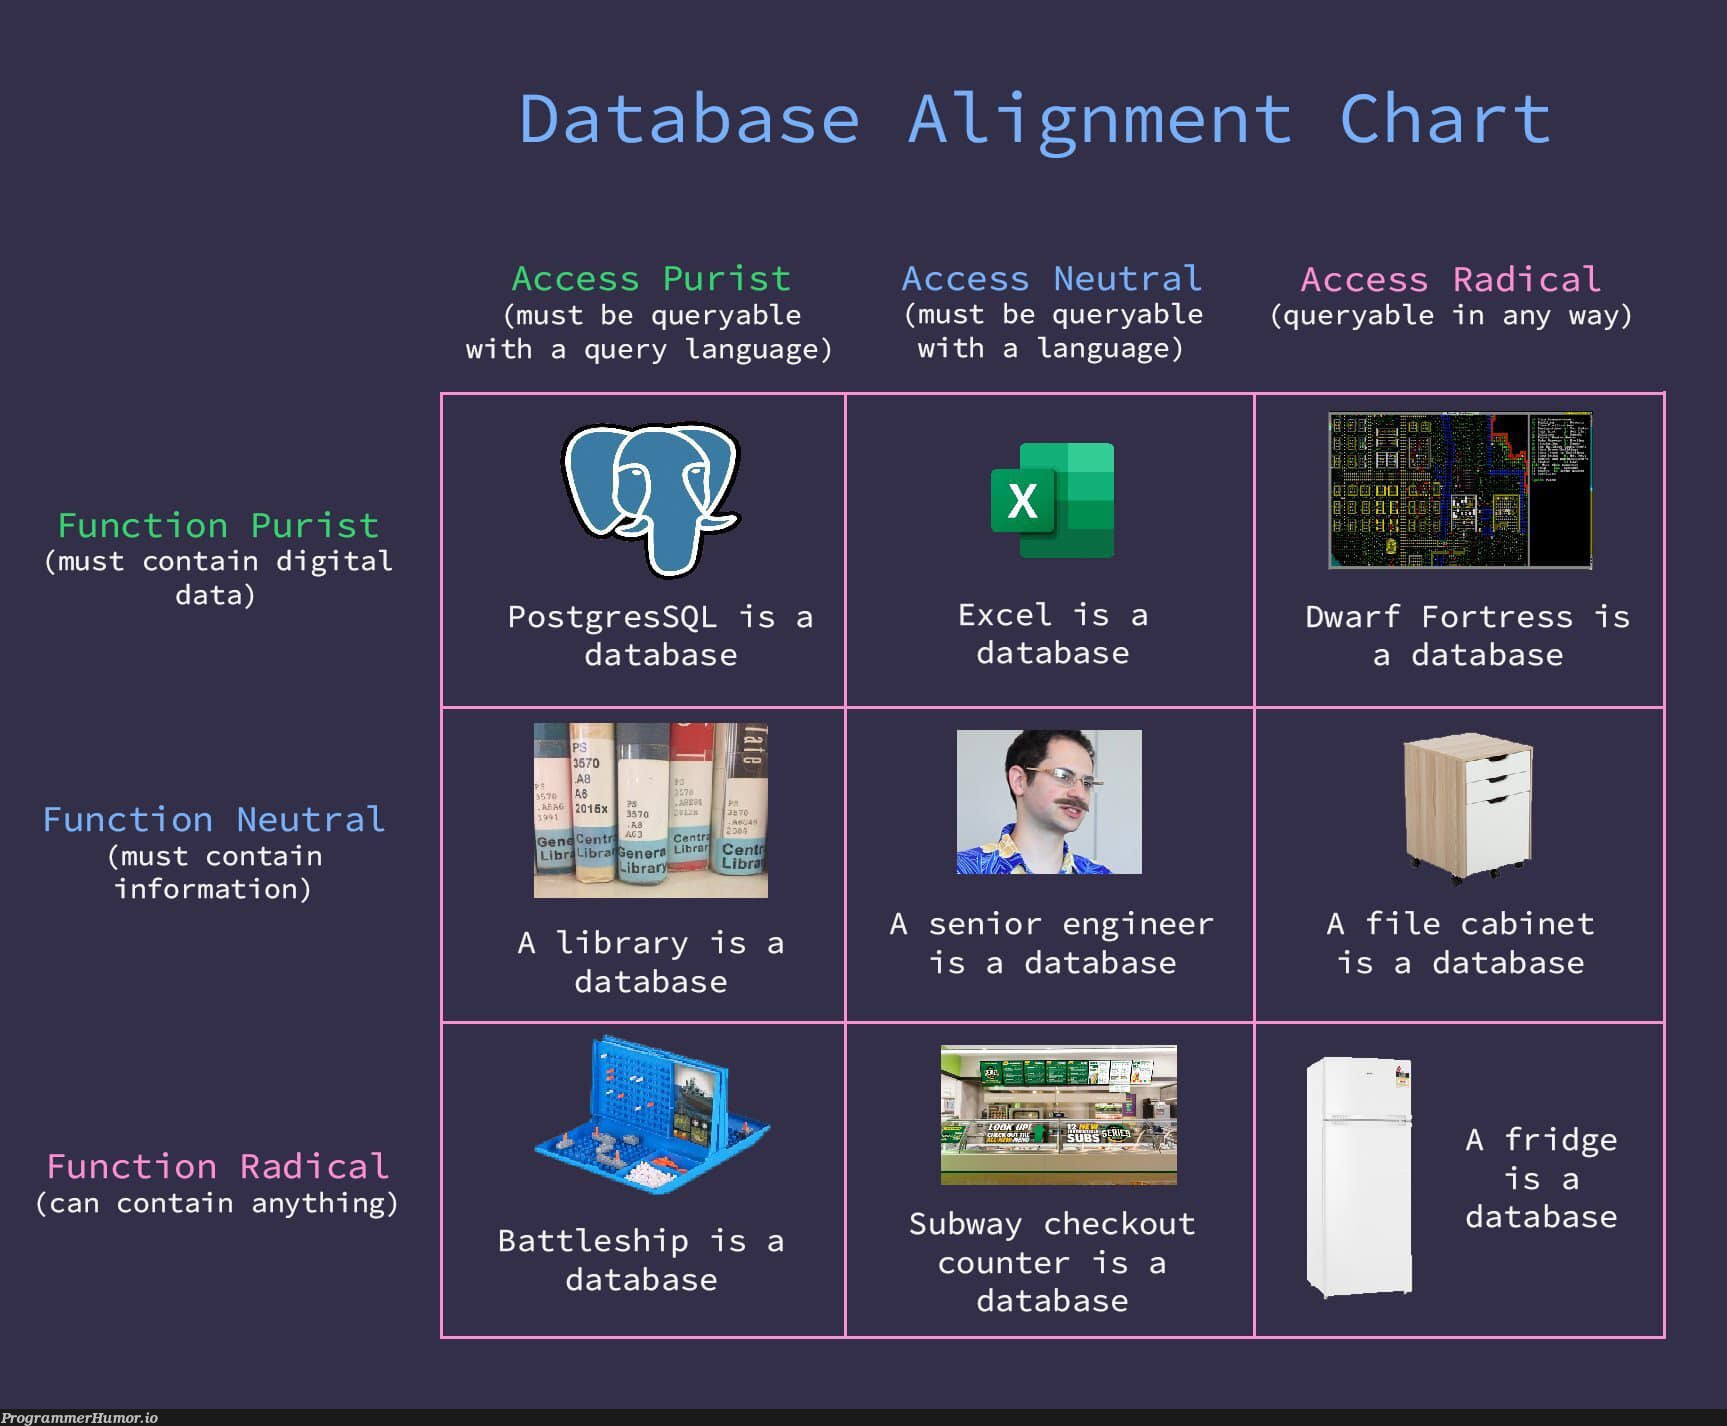

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1mC09rjkheo92-ycjjq0AlIzgwJC8-ZMX#forceEdit=true&sandboxMode=true)!